In [1]:
import csv

import numpy as np
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading custom GW results
savi_all_steps_scores_dict = {}

GW_SIZES = [2**i for i in range(5, 10)]
for gw_size in GW_SIZES:

  # if gw_size > 32: 
  #   break

  for agent_type in ["gru", "gw"]:
    with open(f"rliable-gw-results/ppo_{agent_type}_{gw_size}_all_seeds.csv",'r') as f:
      csv_reader = csv.reader(f)
      csv_data = list(csv_reader)
      
      # for row in csv_data:
      #   for col in row:
      #     for i in range(len(col)):
      #       if col[i] == '':
      #         col[i] = '0'

    csv_data_np = np.array(csv_data[1:])
    # Some runs apparently logged twice as much steps, so skip every two steps to recover
    # an equivalent to the average behavior which should log 1334 steps instead.
    if csv_data_np.shape[0] == 2668:
      csv_data_np = csv_data_np[::2, :]
    # data = pd.read_csv(f"rliable-gw-results/ppo_{agent_type}_{gw_size}_all_seeds.csv").fillna(0)

    # savi_all_steps_scores_dict[f"{agent_type.upper()} {gw_size}"] = csv_data # np.array(csv_data[1:201], dtype=np.float32)[:, 1][None, None, :]
    print(agent_type, gw_size)
    print(csv_data_np.shape)
    # print(csv_data_np[-10:, :2])
    print("")

    agent_type__seed__result_list = []
    for seed_result_idx in range(1, 15, 3):
      # Re-arrange for rliable compatibility
      agent_type__seed__result_list.append(csv_data_np[:, seed_result_idx])
    
    savi_all_steps_scores_dict[f"{agent_type.upper()} {gw_size}"] = \
      np.array(agent_type__seed__result_list, dtype=np.float32)[:, None, :]

savi_all_steps_scores_dict["GRU 32"].shape

gru 32
(1334, 16)

gw 32
(1334, 16)

gru 64
(1334, 16)

gw 64
(1334, 16)

gru 128
(1334, 16)

gw 128
(1334, 16)

gru 256
(1334, 16)

gw 256
(1334, 16)

gru 512
(1334, 16)

gw 512
(1334, 16)



(5, 1, 1334)

<AxesSubplot:xlabel='Time steps', ylabel='IQM Human Normalized Score'>

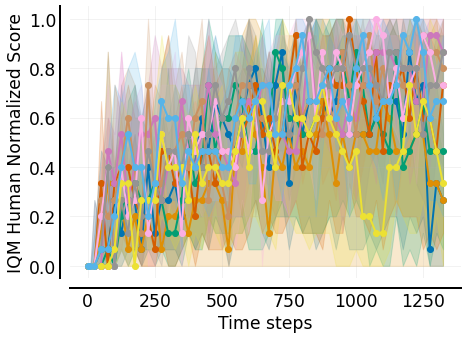

In [3]:
algorithms = [
  *[f"GRU {gw_size}" for gw_size in [2**i for i in range(5, 10)]],
  *[f"GW {gw_size}" for gw_size in [2**i for i in range(5, 10)]],
]; algorithms

# algorithms = [
#   "GRU 32",
#   "GW 32"
# ]; algorithms

# frames = np.array([1, 10, 25, 50, 75, 100, 125, 150, 175, 200]) - 1
frames = np.array([1, 10, *[i for i in range(25, 1334, 25)]]) -1
                          # 25, 50, 75, 100, 125, 150, 175, 200]) - 1
savi_steps_scores_dict = {algorithm: score[:, :, frames] for algorithm, score
                          in savi_all_steps_scores_dict.items()}
iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame])
                               for frame in range(scores.shape[-1])])
iqm_scores, iqm_cis = rly.get_interval_estimates(
  savi_steps_scores_dict, iqm, reps=2000)

plot_utils.plot_sample_efficiency_curve(
    frames+1, iqm_scores, iqm_cis, algorithms=algorithms,
    xlabel=r'Time steps',
    ylabel='IQM Human Normalized Score')

In [4]:
iqm_scores["GRU 32"].shape, iqm_cis["GRU 32"].shape

((55,), (2, 55))

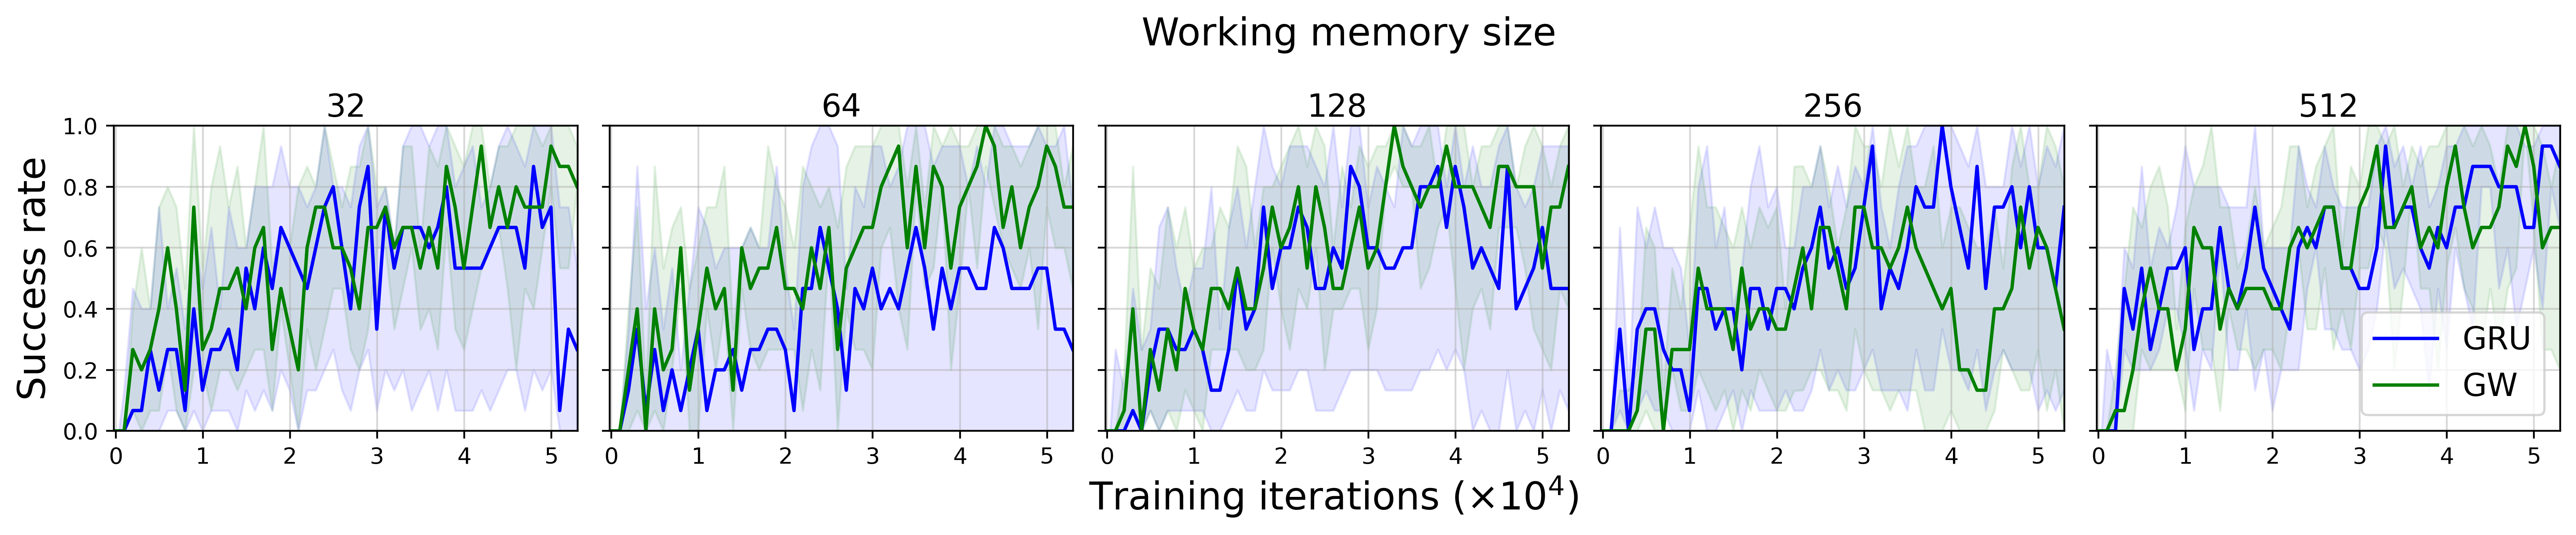

In [6]:
mpl.rcParams.update(mpl.rcParamsDefault)
MAX_STEP = 1301

sns_paired_palette = sns.color_palette("Paired")

fig, axes = plt.subplots(1, 5, figsize=(16, 3), dpi=400, sharey=True)

EXPNAME_TO_COLOR = {
  "GRU": "blue",
  "GW": "green"
}

FONTSIZE = 16

for cidx, gw_size in enumerate(GW_SIZES):
  
  axes[cidx].xaxis.set_label_position("top")
  # if cidx == 2:
  #   axes[cidx].set_xlabel(f"Working memory size\n{gw_size}", fontsize=FONTSIZE)
  # else:
  axes[cidx].set_xlabel(gw_size, fontsize=FONTSIZE-2)
  
  # rliable plotting
  for agent_type in ["GRU", "GW"]:
    algorithm = f"{agent_type} {gw_size}"

    metric_values = iqm_scores[algorithm]
    lower, upper = iqm_cis[algorithm]

    axes[cidx].plot(
      frames,
      metric_values,
      color=EXPNAME_TO_COLOR[agent_type],
      # marker='o',
      # linewidth=kwargs.get('linewidth', 2),
      label=agent_type
    )
    axes[cidx].fill_between(
      frames, y1=lower, y2=upper, color=EXPNAME_TO_COLOR[agent_type], alpha=0.1)


  tick_positions = np.arange(0, 1300 + 1, 250)  # Adjust the step size as needed

  axes[cidx].set_xlim([-5, 1325])
  axes[cidx].set_ylim([-0, 1.0])

  axes[cidx].set_xticks(tick_positions)
  x_tickslabels = [0, 1, 2, 3, 4, 5]
  axes[cidx].set_xticklabels(x_tickslabels)

axes[0].set_ylabel("Success rate", fontsize=FONTSIZE+1)
fig.text(0.5175, -0.035, "Training iterations ($ \\times 10^4$)", ha='center', fontsize=FONTSIZE+1)
fig.suptitle("          Working memory size", fontsize=FONTSIZE+1)
axes[-1].legend(loc="lower right", fontsize=FONTSIZE-2)
for i in range(5):
  axes[i].grid(True, alpha=0.5, zorder=-10,)
fig.tight_layout()

fig.show()

fig.savefig("revised_analysis_plots/GRU_GW_IQM_GW_Size_Grouped.pdf", bbox_inches="tight")